In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns

from glob import glob

import librosa
import librosa.display
import IPython.display as ipd

from itertools import cycle
import random
 
import os
from IPython.display import Audio, display  # Import Audio and display

from sklearn.preprocessing import LabelEncoder

from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift
import noisereduce as nr
from scipy.signal import wiener
import soundfile as sf

#models 

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import BatchNormalization

from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, LSTM, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
%matplotlib inline
sns.set_theme(style="white", palette=None)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])



import tensorflow as tf
import tensorflow_hub as hub
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from xgboost import XGBClassifier
import os
import pandas as pd
from glob import glob
import pickle









import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='librosa')

In [2]:
# Define paths using os to make it more dynamic
home_directory = os.path.expanduser("~")  # Gets the user's home directory
base_directory = os.path.join(home_directory, 'Documents', 'internship_work', 'acoustic_datasets')

# Define CSV and audio directories relative to the base directory
csv_directory = os.path.join(base_directory, 'metadata', 'UrbanSound8K.csv')  # Path to the CSV file
audio_directory = os.path.join(base_directory, 'audio')  # Path to the folder containing audio files

In [3]:
# Load the metadata CSV file
try:
    metadata = pd.read_csv(csv_directory, delimiter=';')
except PermissionError:
    print(f"Permission denied for file: {csv_directory}")
except FileNotFoundError:
    print(f"File not found: {csv_directory}")
except Exception as e:
    print(f"An error occurred: {e}")

# Find all .wav files in the audio directory
audio_files = glob(os.path.join(audio_directory, '*', '*.wav'))

In [4]:
# Print to verify
print(f"Metadata shape: {metadata.shape if 'metadata' in locals() else 'No metadata loaded'}")
print(f"Number of audio files found: {len(audio_files)}")

# Example: load a random audio file with librosa
if audio_files:
    selected_audio_file = random.choice(audio_files)
    y, sr = librosa.load(selected_audio_file)
    print(f"Audio files loaded with sampling rate {sr}")
else:
    print("No audio files found.")

Metadata shape: (8732, 8)
Number of audio files found: 8732
Audio files loaded with sampling rate 22050


In [5]:
# Rename 'slice_file_name' to 'file_name' for consistency
if 'slice_file_name' in metadata.columns:
    metadata.rename(columns={'slice_file_name': 'file_name'}, inplace=True)
else:
    print("The 'slice_file_name' column is missing from the metadata.")
    exit(1)

# Verify the renaming
print(metadata[['file_name', 'classID', 'class']].head())

# Ensure that all audio files have corresponding metadata entries
audio_file_names = [os.path.basename(f) for f in audio_files]
metadata_file_names = metadata['file_name'].unique()

missing_files = set(audio_file_names) - set(metadata_file_names)
if missing_files:
    print(f"Warning: {len(missing_files)} audio files do not have metadata entries.")

# Optionally, filter audio_files to include only those with metadata
audio_files = [f for f in audio_files if os.path.basename(f) in metadata_file_names]
print(f"Total audio files after filtering: {len(audio_files)}")

            file_name  classID             class
0    100032-3-0-0.wav        3          dog_bark
1  100263-2-0-117.wav        2  children_playing
2  100263-2-0-121.wav        2  children_playing
3  100263-2-0-126.wav        2  children_playing
4  100263-2-0-137.wav        2  children_playing
Total audio files after filtering: 8732


In [6]:
# Adding a neutral class
def assign_neutral_class(class_id, known_classes):
    return 10 if class_id not in known_classes else class_id

# List of known classIDs (0 to 9)
known_classes = list(range(10))

# Check if 'classID' column exists
if 'classID' not in metadata.columns:
    print("The 'classID' column is missing from the metadata.")
    exit(1)

# Update 'classID' to include 'neutral' as classID 10
metadata['classID'] = metadata['classID'].apply(lambda x: assign_neutral_class(x, known_classes))

# Create a mapping from classID to class names
class_mapping = {
    0: 'air_conditioner',
    1: 'car_horn',
    2: 'children_playing',
    3: 'dog_bark',
    4: 'drilling',
    5: 'engine_idling',
    6: 'gun_shot',
    7: 'jackhammer',
    8: 'siren',
    9: 'street_music',
    10: 'neutral'
}

# Map classID to class names
metadata['class'] = metadata['classID'].map(class_mapping)

In [7]:
# Display summary information about the DataFrame
print(metadata.info())

# Display summary statistics of numerical columns
print(metadata.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8732 entries, 0 to 8731
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   file_name  8732 non-null   object 
 1   fsID       8732 non-null   int64  
 2   start      8732 non-null   float64
 3   end        8732 non-null   float64
 4   salience   8732 non-null   int64  
 5   fold       8732 non-null   int64  
 6   classID    8732 non-null   int64  
 7   class      8732 non-null   object 
dtypes: float64(2), int64(4), object(2)
memory usage: 545.9+ KB
None
                fsID        start          end     salience         fold  \
count    8732.000000  8732.000000  8732.000000  8732.000000  8732.000000   
mean   116033.493816    38.645409    42.253312     1.347000     5.385937   
std     57991.017218    74.292126    74.369669     0.476043     2.846820   
min       344.000000     0.000000     0.105962     1.000000     1.000000   
25%     69942.250000     3.000000     6.83939

In [8]:
# Check for missing values in critical columns
missing_values = metadata.isnull().sum()
print("Missing values in metadata columns:")
print(missing_values)

# Alternatively, you can check if there are any missing file paths or classes
missing_file_paths = metadata['file_name'].isnull().sum()
missing_folds = metadata['fold'].isnull().sum()
missing_classes = metadata['class'].isnull().sum()

print(f"Missing file paths: {missing_file_paths}")
print(f"Missing folds: {missing_folds}")
print(f"Missing classes: {missing_classes}")

Missing values in metadata columns:
file_name    0
fsID         0
start        0
end          0
salience     0
fold         0
classID      0
class        0
dtype: int64
Missing file paths: 0
Missing folds: 0
Missing classes: 0


In [9]:
### Checking whether the dataset is imbalanced
metadata['class'].value_counts()

class
dog_bark            1000
children_playing    1000
air_conditioner     1000
street_music        1000
engine_idling       1000
jackhammer          1000
drilling            1000
siren                929
car_horn             429
gun_shot             374
Name: count, dtype: int64

# data preprocessing 


In [10]:
def reduce_noise(y, sr, noise_reduce_factor=0.005):
    """Apply noise reduction using spectral subtraction."""
    # Compute the Short-Time Fourier Transform (STFT) of the input signal
    stft = librosa.stft(y)

    # Compute the magnitude and phase
    magnitude, phase = np.abs(stft), np.angle(stft)

    # Estimate the noise profile (mean of the first few frames)
    noise_profile = np.mean(magnitude[:, :int(sr * 0.02)], axis=1)  # assuming noise in the first 20ms

    # Subtract the noise profile from the magnitude (with some reduction factor)
    magnitude_reduced = np.maximum(magnitude - noise_reduce_factor * noise_profile[:, np.newaxis], 0)

    # Reconstruct the signal using the reduced magnitude and the original phase
    stft_reduced = magnitude_reduced * np.exp(1j * phase)
    y_reduced = librosa.istft(stft_reduced)

    return y_reduced


In [11]:
def reduce_noise_if_background(file_name, metadata, y, sr, noise_reduce_factor=0.005):
    """Apply noise reduction if the audio is classified as background sound."""
    file_metadata = metadata[metadata['file_name'] == file_name]
    if not file_metadata.empty:
        salience = file_metadata.iloc[0]['salience']  # Extract salience rating
        if salience == 2:  # If it's a background sound
            print(f"Applying noise reduction to background audio: {file_name}")
            return reduce_noise(y, sr, noise_reduce_factor)
    return y

In [12]:
def play_audio_with_noise_reduction(file_path, metadata, apply_noise_reduction=True, noise_reduce_factor=0.005):
    """Play original and noise-reduced audio."""
    try:
        # Load audio file
        y, sr = librosa.load(file_path, sr=None)

        # Play original audio
        print("Playing original audio:")
        display(Audio(y, rate=sr))  # Play the original sound

        # Apply noise reduction if applicable
        if apply_noise_reduction:
            y_reduced = reduce_noise_if_background(os.path.basename(file_path), metadata, y, sr, noise_reduce_factor)

            # Play noise-reduced audio
            print("Playing audio after noise reduction:")
            display(Audio(y_reduced, rate=sr))  # Play the noise-reduced sound

            return y_reduced
        return y
    except Exception as e:
        print(f"Error playing {file_path}: {e}")
        return None


In [13]:
# Demonstrate with a random audio file and noise reduction
if audio_files:
    demo_audio_file = random.choice(audio_files)  # Select a random audio file
    play_audio_with_noise_reduction(demo_audio_file, metadata)  # Use the noise reduction function
else:
    print("No audio files available for demonstration.")

Playing original audio:


Playing audio after noise reduction:


In [14]:
def reduce_noise(y, sr):
    """Apply noise reduction using spectral gating or another technique."""
    # For demonstration, using librosa's spectral gating (can use other methods)
    spectral_gate = librosa.effects.preemphasis(y)  # basic noise reduction step
    return spectral_gate

def extract_audio_features(audio_files, n_mfcc=40, max_pad_len=174):
    """Extract MFCC, ZCR, Chroma, and Spectral Centroid features from an audio file and pad/truncate to a fixed length."""
    try:
        # Load audio file
        y, sr = librosa.load(audio_files, sr=None)

        # Apply noise reduction
        y = reduce_noise(y, sr)

        # Extract MFCCs
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        mfcc = (mfcc - np.mean(mfcc)) / np.std(mfcc)

        # Extract Zero-Crossing Rate (ZCR)
        zcr = librosa.feature.zero_crossing_rate(y)

        # Extract Chroma features
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)

        # Extract Spectral Centroid
        spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)

        # Padding or truncating to ensure equal length for each feature
        pad_width = max_pad_len - mfcc.shape[1]
        if pad_width > 0:
            mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
            zcr = np.pad(zcr, pad_width=((0, 0), (0, pad_width)), mode='constant')
            chroma = np.pad(chroma, pad_width=((0, 0), (0, pad_width)), mode='constant')
            spectral_centroid = np.pad(spectral_centroid, pad_width=((0, 0), (0, pad_width)), mode='constant')
        else:
            mfcc = mfcc[:, :max_pad_len]
            zcr = zcr[:, :max_pad_len]
            chroma = chroma[:, :max_pad_len]
            spectral_centroid = spectral_centroid[:, :max_pad_len]

        # Combine features into a single array or return them separately based on the application
        features = np.vstack([mfcc, zcr, chroma, spectral_centroid])

        return features

    except Exception as e:
        print(f"Error extracting features for {audio_files}: {e}")
        return None


In [15]:

def prepare_data(metadata, audio_files, n_mfcc=40, max_pad_len=174):
    """Prepare feature and label arrays for modeling with noise reduction and multiple feature extraction (MFCC, ZCR, Chroma, Spectral Centroid)."""
    features = []
    labels = []
    file_names = []

    for index, row in metadata.iterrows():
        file_name = row['file_name']
        class_label = row['class']
        fold = row['fold']  # Retrieve fold number

        # Construct full file path
        file_path = os.path.join(audio_files, f'fold{fold}', file_name)

        if os.path.exists(file_path):
            # Extract features (MFCC, ZCR, Chroma, and Spectral Centroid)
            feature = extract_audio_features(file_path, n_mfcc, max_pad_len)
            if feature is not None:
                features.append(feature)
                labels.append(class_label)
                file_names.append(file_name)
        else:
            print(f"File not found: {file_path}")

    return np.array(features), np.array(labels), file_names


In [16]:
# Prepare the data using the updated feature extraction method
X, y, file_names = prepare_data(metadata, audio_directory)

# Print the shape of the feature and labels arrays
print(f"Feature array shape: {X.shape}")
print(f"Labels array shape: {y.shape}")


Feature array shape: (8732, 54, 174)
Labels array shape: (8732,)


# Models 

In [17]:
# Label encoding
def encode_labels(y):
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    return y_encoded, le

In [18]:
 # Encode labels
y_encoded, label_encoder = encode_labels(y)#


In [19]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [20]:
from hmmlearn import hmm
# Training and testing the HMM model
def train_hmm(X_train, y_train, n_components=4):
    models = {}
    for label in np.unique(y_train):
        # Extract all training samples with the same label
        X_label = [X_train[i] for i in range(len(X_train)) if y_train[i] == label]
        
        # Flatten the sequences to train HMM
        X_label = np.vstack(X_label)
        
        # Train a GaussianHMM for this class
        model = hmm.GaussianHMM(n_components=n_components, covariance_type='diag', n_iter=100)
        model.fit(X_label)
        
        models[label] = model
    return models

In [21]:
# Predict using HMM models
def predict_hmm(models, X_test):
    y_pred = []
    for x in X_test:
        max_score = float('-inf')
        best_label = None
        for label, model in models.items():
            try:
                score = model.score(x)
                if score > max_score:
                    max_score = score
                    best_label = label
            except:
                continue
        y_pred.append(best_label)
    return y_pred

In [22]:
# Train the HMM model
models = train_hmm(X_train, y_train, n_components=4)

# Predict on the test set
y_pred = predict_hmm(models, X_test)

# Convert predicted and true labels back to original labels
y_pred_labels = label_encoder.inverse_transform(y_pred)
y_test_labels = label_encoder.inverse_transform(y_test)

# Evaluate the model
print("Classification Report:\n", classification_report(y_test_labels, y_pred_labels))
print("Accuracy:", accuracy_score(y_test_labels, y_pred_labels))


Model is not converging.  Current: -3957365.310192358 is not greater than -3957361.0851647365. Delta is -4.2250276217237115


Classification Report:
                   precision    recall  f1-score   support

 air_conditioner       0.26      0.36      0.31       203
        car_horn       0.23      0.42      0.30        86
children_playing       0.22      0.13      0.16       183
        dog_bark       0.67      0.08      0.14       201
        drilling       0.54      0.12      0.20       206
   engine_idling       0.23      0.50      0.32       193
        gun_shot       0.43      0.21      0.28        72
      jackhammer       0.33      0.30      0.32       208
           siren       0.31      0.47      0.38       165
    street_music       0.21      0.22      0.21       230

        accuracy                           0.27      1747
       macro avg       0.34      0.28      0.26      1747
    weighted avg       0.35      0.27      0.25      1747

Accuracy: 0.273039496279336


In [23]:
# Load YAMNet model
yamnet_model = hub.load('https://tfhub.dev/google/yamnet/1')

# Function to extract embeddings using YAMNet
def extract_yamnet_features(file_path):
    # Load the audio file
    y, sr = librosa.load(file_path, sr=16000)
    
    # Ensure the waveform is a 1D array as expected by YAMNet
    waveform = tf.convert_to_tensor(y, dtype=tf.float32)

    # Run YAMNet model
    yamnet_scores, yamnet_embeddings, yamnet_log_mel_spectrogram = yamnet_model(waveform)
    
    # The embeddings output shape is (num_patches, embedding_size)
    # We take the mean of all patches to get a fixed-size embedding per file
    embedding = np.mean(yamnet_embeddings, axis=0)

    return embedding

# Load audio files and extract features using YAMNet
def prepare_data_with_yamnet(metadata, audio_files):
    X, y, file_names = [], [], []
    for idx, row in metadata.iterrows():
        file_name = row['slice_file_name']
        fold = row['fold']
        label = row['class']
        
        # Construct full file path
        file_path = os.path.join(audio_directory, f'fold{fold}', file_name)
        
        if os.path.exists(file_path):
            # Extract features using YAMNet
            feature = extract_yamnet_features(file_path)
            X.append(feature)
            y.append(label)
            file_names.append(file_name)
    
    return np.array(X), np.array(y), file_names

# Label encoding
def encode_labels(y):
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    return y_encoded, le

# Define paths
home_directory = os.path.expanduser("~")  # Gets the user's home directory
base_directory = os.path.join(home_directory, 'Documents', 'internship_work', 'acoustic_datasets')
csv_directory = os.path.join(base_directory, 'metadata', 'UrbanSound8K.csv')  # Path to the CSV file
audio_directory = os.path.join(base_directory, 'audio')  # Path to the folder containing audio files

# Load metadata and audio files
metadata = pd.read_csv(csv_directory, delimiter=';')
audio_files = glob(os.path.join(audio_directory, '*', '*.wav'))

# Prepare the data using YAMNet
X, y, file_names = prepare_data_with_yamnet(metadata, audio_files)

# Encode labels
y_encoded, label_encoder = encode_labels(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Train the XGBoost model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train, y_train)

# Predict on the test set
y_pred = xgb_model.predict(X_test)

# Convert predicted and true labels back to original labels
y_pred_labels = label_encoder.inverse_transform(y_pred)
y_test_labels = label_encoder.inverse_transform(y_test)

# Evaluate the model
print("Classification Report:\n", classification_report(y_test_labels, y_pred_labels))
print("Accuracy:", accuracy_score(y_test_labels, y_pred_labels))




c:\Users\Huawei\anaconda3\envs\NLP_CLASSIFICATION\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:44:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Classification Report:
                   precision    recall  f1-score   support

 air_conditioner       0.90      0.94      0.92       203
        car_horn       0.92      0.91      0.91        86
children_playing       0.92      0.94      0.93       183
        dog_bark       0.96      0.90      0.93       201
        drilling       0.93      0.92      0.93       206
   engine_idling       0.95      0.92      0.93       193
        gun_shot       0.96      0.96      0.96        72
      jackhammer       0.91      0.94      0.92       208
           siren       0.95      0.98      0.96       165
    street_music       0.92      0.91      0.92       230

        accuracy                           0.93      1747
       macro avg       0.93      0.93      0.93      1747
    weighted avg       0.93      0.93      0.93      1747

Accuracy: 0.929593589009731


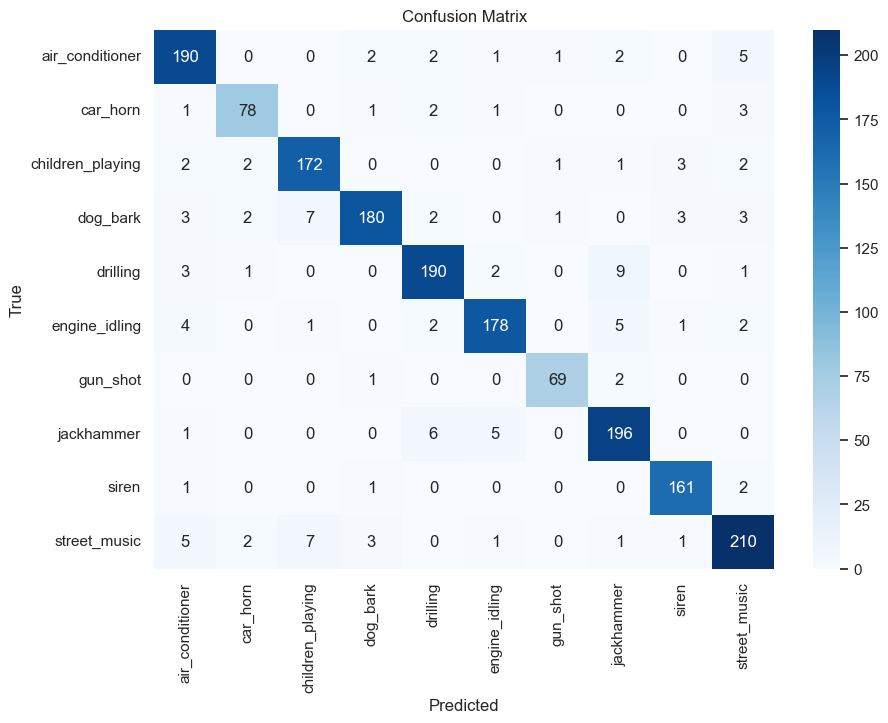

In [24]:

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Convert predicted and true labels back to original labels for confusion matrix
y_pred_labels = label_encoder.inverse_transform(y_pred)
y_test_labels = label_encoder.inverse_transform(y_test)

# Get the list of unique labels (classes)
unique_labels = label_encoder.classes_

# Plot confusion matrix
plot_confusion_matrix(y_test_labels, y_pred_labels, unique_labels)


              Class  Percentage
0          dog_bark   11.452130
1  children_playing   11.452130
2   air_conditioner   11.452130
3      street_music   11.452130
4     engine_idling   11.452130
5        jackhammer   11.452130
6          drilling   11.452130
7             siren   10.639029
8          car_horn    4.912964
9          gun_shot    4.283097


C:\Users\Huawei\AppData\Local\Temp\ipykernel_35092\1938501408.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=class_distribution_df, x='Class', y='Percentage', palette='viridis')


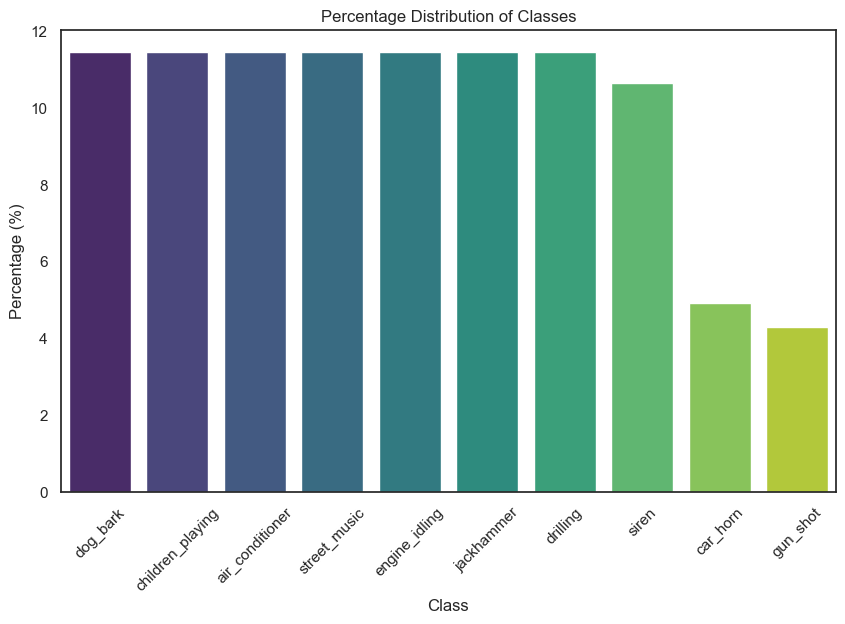

In [25]:
# Assuming 'y' contains the original labels before encoding
# Calculate the count of each class using original labels
class_counts = pd.Series(y).value_counts()

# Calculate the percentage distribution
class_distribution = (class_counts / class_counts.sum()) * 100

# The index is already the original class labels
# Convert count series to a DataFrame for easier handling
class_distribution_df = class_distribution.reset_index()
class_distribution_df.columns = ['Class', 'Percentage']

# Display the distribution as a DataFrame
print(class_distribution_df)

# Visualize the distribution using a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(data=class_distribution_df, x='Class', y='Percentage', palette='viridis')
plt.title('Percentage Distribution of Classes')
plt.ylabel('Percentage (%)')
plt.xlabel('Class')
plt.xticks(rotation=45)
plt.show()

In [26]:
# Directory where the model and encoder will be saved
model_directory = os.path.join(home_directory, 'Documents', 'internship_work', 'models')
os.makedirs(model_directory, exist_ok=True)

# File paths for the model and label encoder
model_path = os.path.join(model_directory, 'xgboost_yamnet_model.pkl')
label_encoder_path = os.path.join(model_directory, 'label_encoder.pkl')

# Save the XGBoost model
with open(model_path, 'wb') as model_file:
    pickle.dump(xgb_model, model_file)
print(f"XGBoost model saved to {model_path}")

# Save the label encoder
with open(label_encoder_path, 'wb') as le_file:
    pickle.dump(label_encoder, le_file)
print(f"Label encoder saved to {label_encoder_path}")


XGBoost model saved to C:\Users\Huawei\Documents\internship_work\models\xgboost_yamnet_model.pkl
Label encoder saved to C:\Users\Huawei\Documents\internship_work\models\label_encoder.pkl
